In [134]:
from functools import reduce
from pathlib import Path
from typing import List, Optional, Tuple

import torch
from decord import VideoReader, cpu
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import towhee

import ilids.towhee_utils.override.movinet
import ilids.towhee_utils.cached_video_decoder


In [2]:
ALL_MOVINET_MODELS = [
    "movineta0",
    "movineta1",
    "movineta2",
    "movineta3",
    "movineta4",
    "movineta5",
]

In [3]:
video_decoder = towhee.glob["path"]("../data/sequences/*.mp4").video_decode.ffmpeg["path", "frames"]().ilids.cached_video_decoder[("path", "frames"), "frames"]()

In [17]:
def movinet_classification(video_decoder, model_name: str) -> towhee.DataCollection:
    net_classification = (
        video_decoder
        .ilids.movinet["frames", ("labels", "scores", "features")](model_name=model_name)
    )

    th_df: towhee.DataFrame = net_classification.select["path", "labels", "scores", "features"]()

    return th_df.fill_entity(dict(model_name=model_name)).to_dc()


In [18]:
movinet_classification_dcs = [
    movinet_classification(video_decoder, model_name)
    for model_name in ALL_MOVINET_MODELS
]


In [19]:
joined_dc: towhee.DataCollection = reduce(lambda i, j: i + j, movinet_classification_dcs)


In [46]:
label_score_df = pd.DataFrame([dict(**{"class": "TP" in classification_entity.path}, model_name=classification_entity.model_name, video=classification_entity.path, label=topk_label, score=topk_score) for classification_entity in joined_dc for topk_label, topk_score in zip(classification_entity.labels, classification_entity.scores)])
label_score_df.head()

class model_name                                              video  \
0  False  movineta0  ../data/sequences/SZTR_video_SZTRA201a09_00_00...   
1  False  movineta0  ../data/sequences/SZTR_video_SZTRA201a09_00_00...   
2  False  movineta0  ../data/sequences/SZTR_video_SZTRA201a09_00_00...   
3  False  movineta0  ../data/sequences/SZTR_video_SZTRA201a09_00_00...   
4  False  movineta0  ../data/sequences/SZTR_video_SZTRA201a09_00_00...   

                label  score  
0       shaking hands    1.0  
1  playing didgeridoo    0.0  
2      stretching arm    0.0  
3    playing recorder    0.0  
4     finger snapping    0.0

In [47]:
VIDEOS = label_score_df.sort_values(by="class")["video"].unique()

array(['../data/sequences/SZTR_video_SZTRA201a09_00_00_58_FP.mp4',
       '../data/sequences/SZTR_video_SZTRA104b10_00_00_03_FP.mp4',
       '../data/sequences/SZTR_video_SZTRA202b06_00_00_59_FP.mp4',
       '../data/sequences/SZTR_video_SZTRA203a12_00_00_55_FP.mp4',
       '../data/sequences/SZTR_video_SZTRA202b11_00_01_26_FP.mp4',
       '../data/sequences/SZTR_video_SZTRA103a17_00_00_09_TP.mp4',
       '../data/sequences/SZTR_video_SZTRA203a17_00_00_10_TP.mp4',
       '../data/sequences/SZTR_video_SZTRA203b17_00_00_13_TP.mp4',
       '../data/sequences/SZTR_video_SZTRA102b13_00_00_20_TP.mp4',
       '../data/sequences/SZTR_video_SZTRA202b13_00_00_19_TP.mp4'],
      dtype=object)

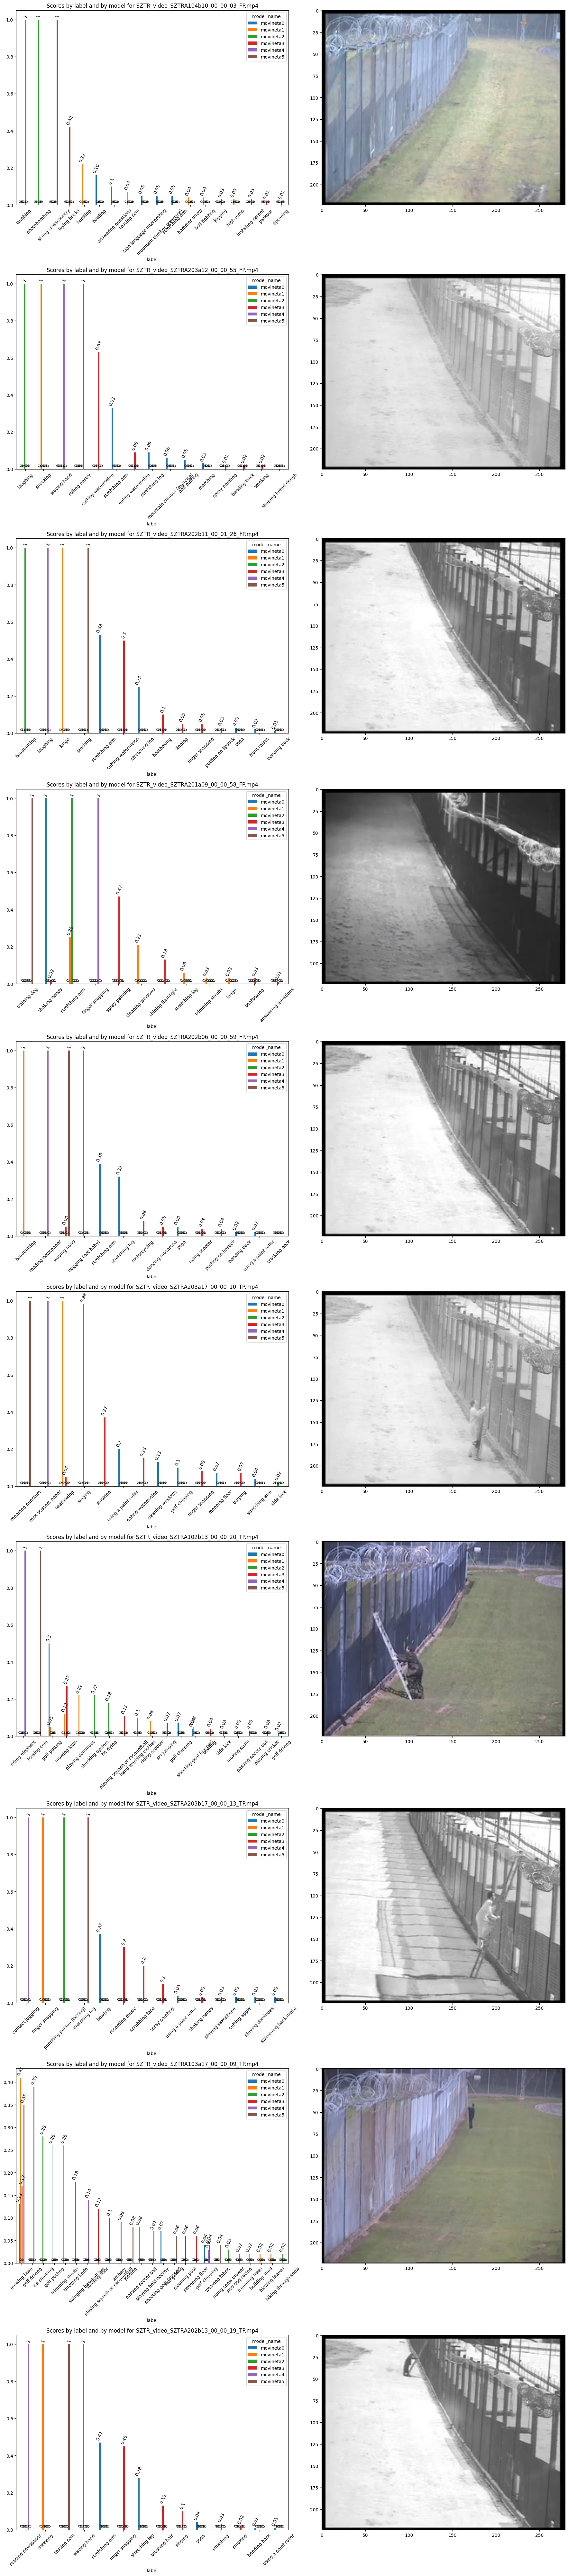

In [42]:
def get_middle_frame(frame: Path):
    vr = VideoReader(str(frame), ctx=cpu(0))
    middle_frame_idx = int(len(vr) / 2)

    frame = vr[middle_frame_idx]

    return Image.fromarray(frame.asnumpy())


# get_middle_frame(Path(df.iloc[0]["path"]))
def plot_score_by_label_model(path: str, axs: List):
    path_df = label_score_df[label_score_df["video"] == path].first_path_model_df(columns="video")
    pivot_df = path_df.pivot(index="label", columns="model_name", values="score")

    pivot_df["mean"] = pivot_df.mean(axis=1)
    pivot_df["max"] = pivot_df.max(axis=1)

    pivot_df = pivot_df[pivot_df["max"] > 0]

    pivot_df = pivot_df.sort_values(by=["max", "mean"], ascending=False).first_path_model_df(columns=["max", "mean"])

    bar_ax, img_ax = axs

    pivot_df.round(decimals=2).plot(kind="bar", ax=bar_ax, rot=45,
                                    title=f"Scores by label and by model for {Path(path).name}")
    for container in bar_ax.containers:
        bar_ax.bar_label(container, padding=3, rotation=65)

    img_ax.imshow(get_middle_frame(Path(path)))


fig, axs = plt.subplots(
    # len(VIDEOS), 2, figsize=(18, len(VIDEOS) * 24), constrained_layout=True
    len(VIDEOS), 2, figsize=(18, 80), constrained_layout=True
)
for ax_row, video in zip(axs, VIDEOS):
    plot_score_by_label_model(video, ax_row)

# fig.tight_layout()

plt.show()


In [126]:
softmax = torch.nn.Softmax(dim=0)

def apply_softmax(array: List[float]) -> List[float]:
    return softmax(torch.tensor(array)).numpy().tolist()

softmax_features_df = pd.DataFrame([["TP" in classification_entity.path, classification_entity.model_name, classification_entity.path, *apply_softmax(classification_entity.features)] for classification_entity in joined_dc], columns=(["class", "model_name", "path"] + [i for i in range(600)]))

features_df = pd.DataFrame([["TP" in classification_entity.path, classification_entity.model_name, classification_entity.path, *classification_entity.features] for classification_entity in joined_dc], columns=(["class", "model_name", "path"] + [i for i in range(600)]))


In [127]:
tp_df = features_df[softmax_features_df["class"]].drop(columns="class")
softmax_tp_df = softmax_features_df[softmax_features_df["class"]].drop(columns="class")
fp_df = features_df[~features_df["class"]].drop(columns="class")

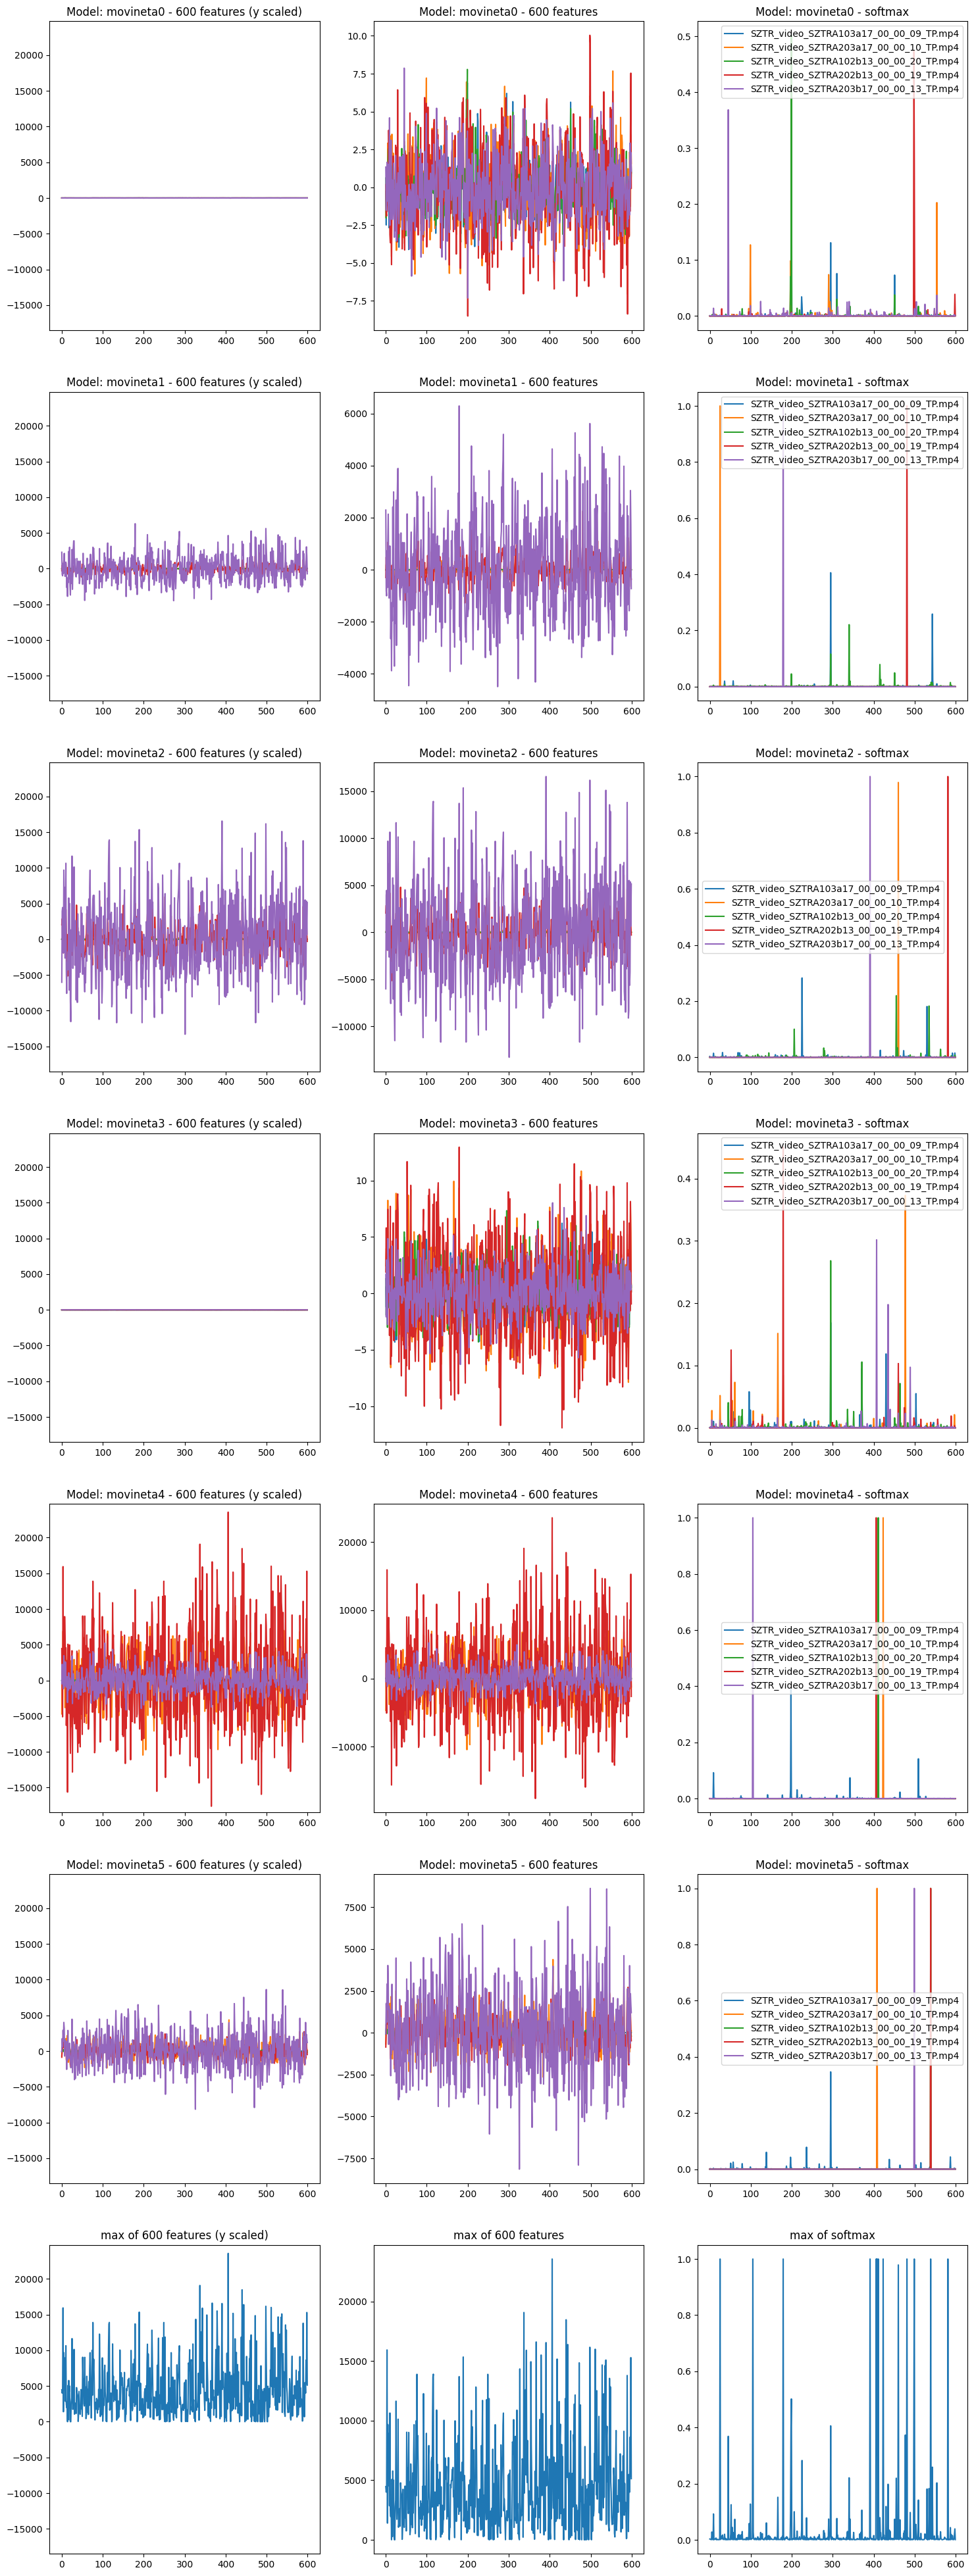

In [147]:
fig, axs = plt.subplots(len(ALL_MOVINET_MODELS) + 1, 3, figsize=(18, 50))

features_only_df = tp_df[pd.RangeIndex.from_range(range(600))]

min_y, max_y = features_only_df.min().min(), features_only_df.max().max()

min_y *= 1.05
max_y *= 1.05

def plot_models_amplitude(df: pd.DataFrame, model_name: str, ax, title_suffix : str, legend: bool = True, ylim : Optional[Tuple] = None):
    amplitude_df = df[df["model_name"] == model_name].melt(["model_name", "path"], var_name="feature_N", value_name="amplitude")

    def plot_amplitude(path: str):
        path_amplitude_series = amplitude_df[amplitude_df["path"] == path]["amplitude"].rename(str(Path(path).name)).reset_index(drop=True)
        assert len(path_amplitude_series) == 600

        path_amplitude_series.plot(kind="line", ax=ax, legend=legend, ylim=ylim)

    for path in amplitude_df["path"].unique():
        plot_amplitude(path)

    ax.set_title(f"Model: {model_name} - {title_suffix}")

for model_name, (ax_left, ax_middle, ax_right) in zip(ALL_MOVINET_MODELS, axs):
    plot_models_amplitude(tp_df, model_name, ax_left, "600 features (y scaled)", legend=False, ylim=(min_y, max_y))
    plot_models_amplitude(tp_df, model_name, ax_middle, "600 features", legend=False)
    plot_models_amplitude(softmax_tp_df, model_name, ax_right, "softmax", legend=True)

last_ax_left, last_ax_middle, last_ax_right = axs[-1]

tp_df[pd.RangeIndex.from_range(range(600))].max(axis=0).plot(kind="line", ax=last_ax_left, ylim=(min_y, max_y), title="max of 600 features (y scaled)")
tp_df[pd.RangeIndex.from_range(range(600))].max(axis=0).plot(kind="line", ax=last_ax_middle, title="max of 600 features")
softmax_tp_df[pd.RangeIndex.from_range(range(600))].max(axis=0).plot(kind="line", ax=last_ax_right, title="max of softmax")

plt.show()


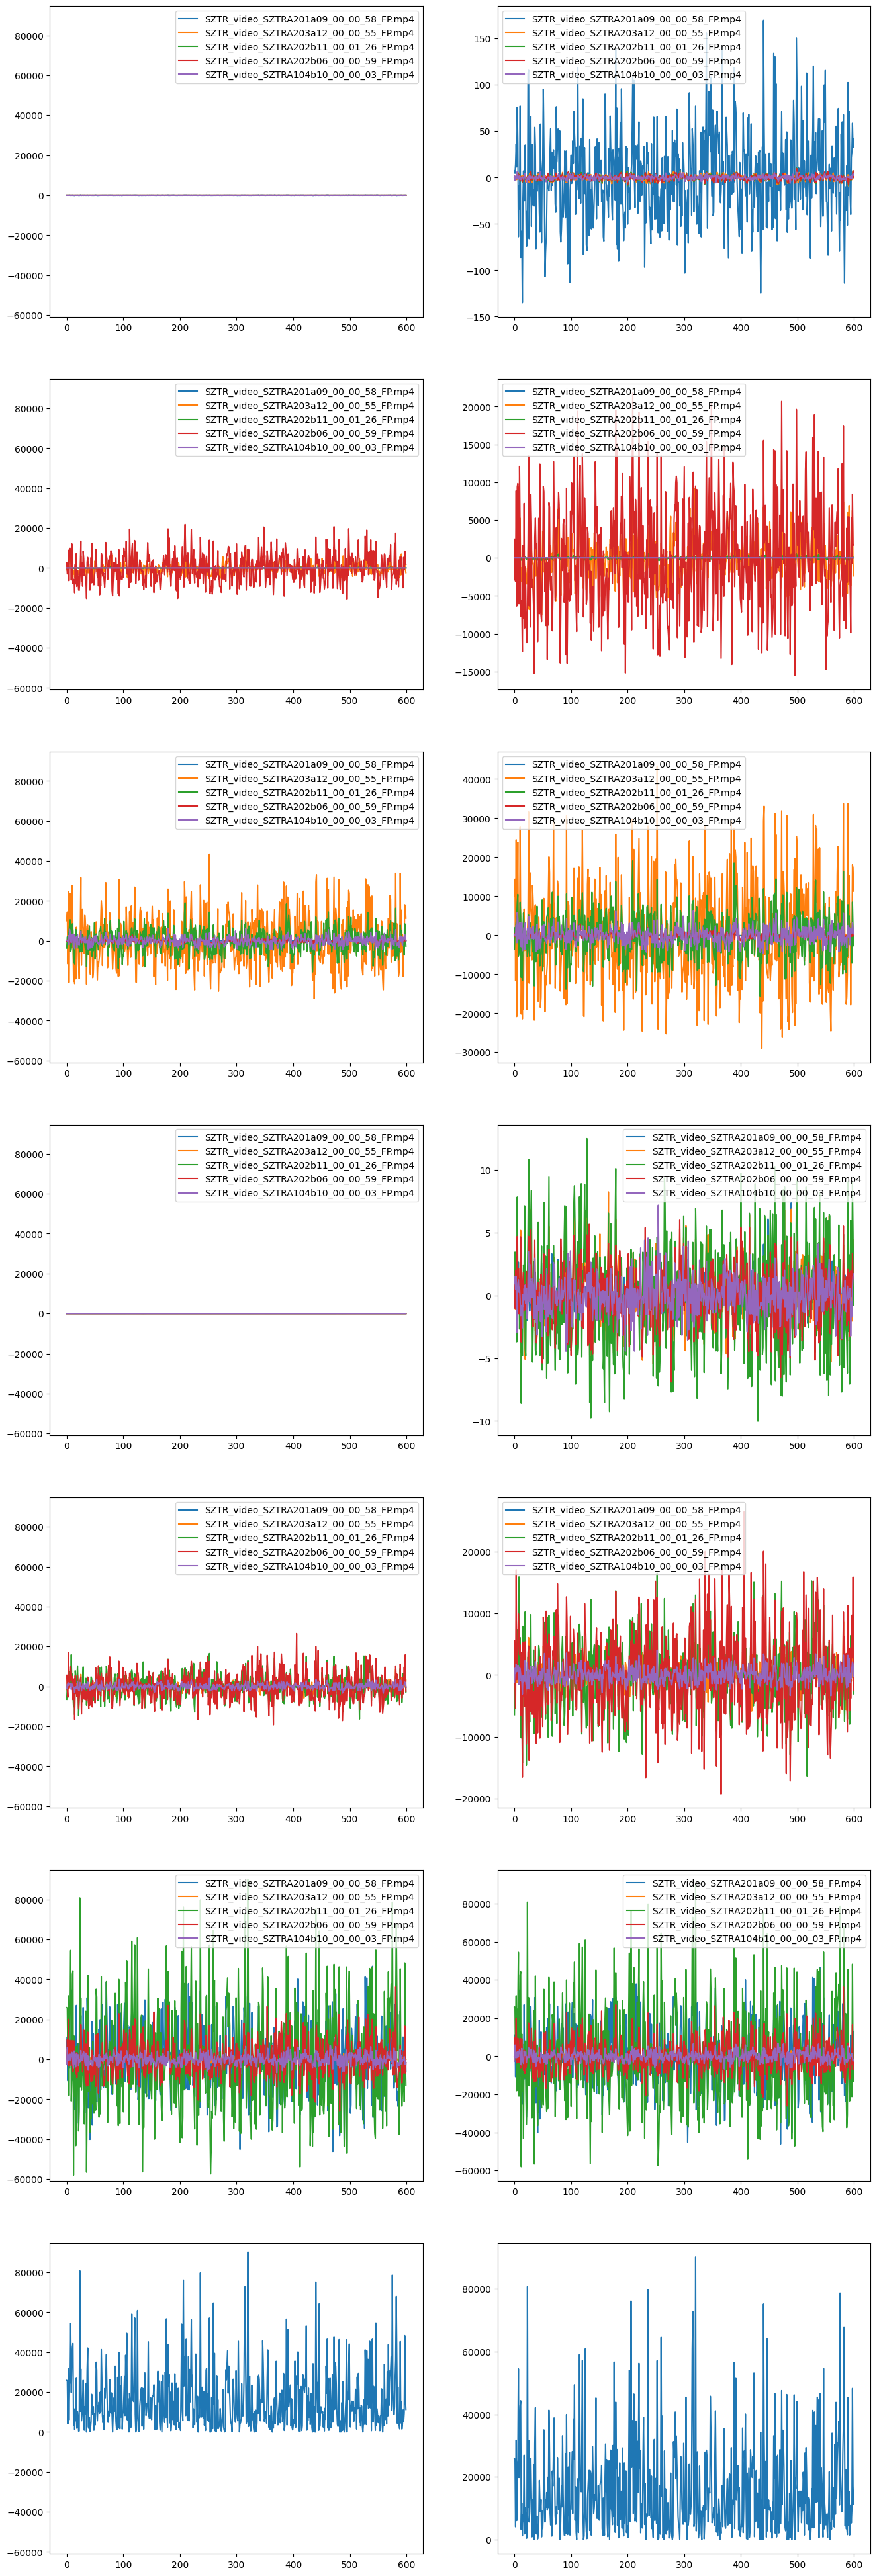

In [149]:
fig, axs = plt.subplots(len(ALL_MOVINET_MODELS) + 1, 2, figsize=(16, 50))

features_only_df = fp_df[pd.RangeIndex.from_range(range(600))]

min_y, max_y = features_only_df.min().min(), features_only_df.max().max()

min_y *= 1.05
max_y *= 1.05

def plot_models_amplitude(model_name: str, row_axs):
    amplitude_df = fp_df[fp_df["model_name"] == model_name].melt(["model_name", "path"], var_name="feature_N", value_name="amplitude")

    def plot_amplitude(path: str):
        path_amplitude_series = amplitude_df[amplitude_df["path"] == path]["amplitude"].rename(str(Path(path).name)).reset_index(drop=True)
        assert len(path_amplitude_series) == 600

        path_amplitude_series.plot(kind="line", ax=row_axs[0], legend=True, ylim=(min_y, max_y))
        path_amplitude_series.plot(kind="line", ax=row_axs[1], legend=True)

    for path in amplitude_df["path"].unique():
        plot_amplitude(path)

    ax.set_title(f"Model's 600 features [{model_name}]")

for model_name, row_axs in zip(ALL_MOVINET_MODELS, axs):
    plot_models_amplitude(model_name, row_axs)

features_only_df.max(axis=0).plot(kind="line", ax=axs[-1][0], ylim=(min_y, max_y))
features_only_df.max(axis=0).plot(kind="line", ax=axs[-1][1])

plt.show()
